In [31]:
import io
import pandas as pd
import boto3
import configparser

config = configparser.ConfigParser()
config.read('config/escec.cfg')

['config/escec.cfg']

In [32]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

S3_BUCKET_NAME = 'bucket-23000712'

In [33]:
try:
    file = s3.Bucket(S3_BUCKET_NAME).Object('df_rental.xlsx').get()
    data = file['Body'].read()
    df_rental = pd.read_excel(io.BytesIO(data), engine='openpyxl')
except Exception as ex:
    print("No es un archivo.")
    print(ex)

In [34]:
df_rental.head()

,id_rental,name_customer,license_customer,brand_vehicle,model_vehicle,model_year_vehicle,mileage_vehicle,color_vehicle,type_vehicle,rental_value,...,year_start,street_address_end,city_end,state_end,date_end,day_of_week_end,day_num_in_month_end,day_name_end,quarter_end,year_end
0,1,Kelby Matterdace,V435899293,Chevrolet,Cruze,2017,45796,dark gray,Intermediate,29.45,...,2018,310 E 64th St,New York,New York,2018-07-23,1,23,Monday,3,2018
1,1,Kelby Matterdace,V435899293,Hyundai,Elantra,2018,35479,black,Intermediate,29.45,...,2018,310 E 64th St,New York,New York,2018-07-23,1,23,Monday,3,2018
2,2,Orion De Hooge,Z140530509,Nissan,Versa,2016,65956,white,Economy,26.77,...,2018,300 Reunion Blvd,Dallas,Texas,2018-07-12,4,12,Thursday,3,2018
3,2,Orion De Hooge,Z140530509,Mitsubishi,Mirage,2017,55864,light blue,Economy,26.77,...,2018,300 Reunion Blvd,Dallas,Texas,2018-07-12,4,12,Thursday,3,2018
4,3,Sheena Macias,W045654959,Nissan,Versa,2016,65956,white,Economy,26.77,...,2018,1011 Pike St,Seattle,Washington,2018-07-20,5,20,Friday,3,2018


## Distribución de renta de vehículos

In [53]:
df_distrib = df_rental["rental_value"].describe()
df_distrib

count    654.000000
mean      30.767798
std        4.090677
min       26.770000
25%       26.770000
50%       29.450000
75%       34.810000
max       37.480000
Name: rental_value, dtype: float64

## Vehículos rentados por Marca

¿Cuántos vehículos de cada marca han sido rentados?

In [42]:
popular_vehicles = df_rental.groupby(['brand_vehicle', 'model_vehicle', 'type_vehicle']).size().reset_index(name='counts')
popular_vehicles

,brand_vehicle,model_vehicle,type_vehicle,counts
0,Chevrolet,Cruze,Intermediate,99
1,Hyundai,Elantra,Intermediate,99
2,Mitsubishi,Mirage,Economy,117
3,Nissan,Versa,Economy,117
4,Toyota,RAV4,Economy SUV,112
5,Volkswagen,Jetta,Standard,110


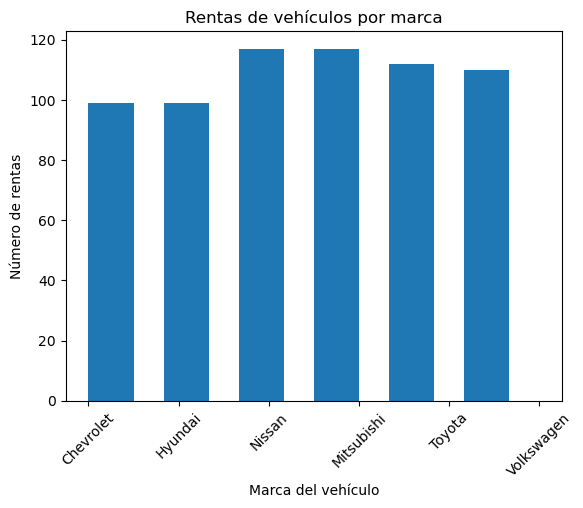

In [91]:
marcas = df_rental['brand_vehicle'].unique()

plt.hist(df_rental['brand_vehicle'], bins=len(marcas), width=0.5)
plt.xticks(range(len(marcas)), marcas, rotation=90)
plt.xlabel('Marca del vehículo')
plt.ylabel('Número de rentas')
plt.title('Rentas de vehículos por marca')
plt.xticks(rotation=45)
plt.show()

## Kilómetros en promedio por tipo de vehículo

¿Cuál es el promedio de kilometraje de los vehículos rentados por tipo de vehículo?

In [71]:
df_mean_mileage = df_rental.groupby('type_vehicle')['mileage_vehicle'].mean()
df_mean_mileage

type_vehicle
Economy         60910.0
Economy SUV     12566.0
Intermediate    40637.5
Standard         2032.0
Name: mileage_vehicle, dtype: float64

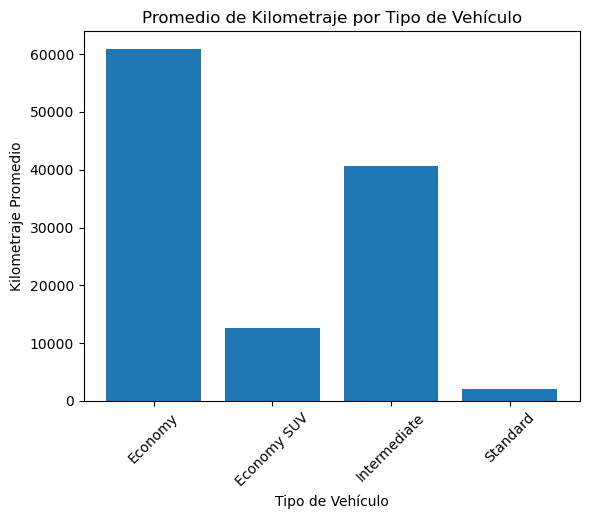

In [74]:
# crear la figura y el eje
fig, ax = plt.subplots()

# crear el gráfico de barras
ax.bar(df_mean_mileage.index, df_mean_mileage.values)

# establecer el título y las etiquetas de los ejes
ax.set_title('Promedio de Kilometraje por Tipo de Vehículo')
ax.set_xlabel('Tipo de Vehículo')
ax.set_ylabel('Kilometraje Promedio')

# rotar las etiquetas del eje X para que sean legibles
plt.xticks(rotation=45)

# mostrar la gráfica
plt.show()

## Rentas por día de la semana

¿Cuáles son los días de la semana con la mayor y menor demanda de alquiler de vehículos?

In [78]:
df_rentas_por_dia_semana = df_rental.groupby('day_name_start').size().sort_values(ascending=True)
df_rentas_por_dia_semana

day_name_start
Thursday      76
Sunday        86
Tuesday       89
Friday        91
Wednesday     98
Saturday     105
Monday       109
dtype: int64

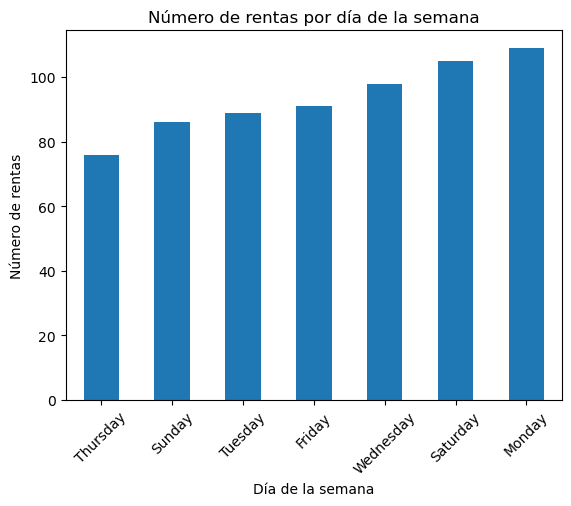

In [80]:
df_rentas_por_dia_semana.plot(kind='bar')

plt.title('Número de rentas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Número de rentas')
plt.xticks(rotation=45)

plt.show()

## Rentas por día mes

¿Cuál es el mes que registra mayor número de rentas?

In [64]:
df_rental2 = df_rental
df_rental2['date_start'] = pd.to_datetime(df_rental2['date_start']) # convertir a tipo de datos fecha
rentas_por_mes = df_rental2.groupby(df_rental2['date_start'].dt.to_period('M')).count()['id_rental']
rentas_por_mes

date_start
2017-12    27
2018-01    57
2018-02    60
2018-03    53
2018-04    31
2018-05    48
2018-06    70
2018-07    72
2018-08    54
2018-09    47
2018-10    56
2018-11    56
2018-12    23
Freq: M, Name: id_rental, dtype: int64

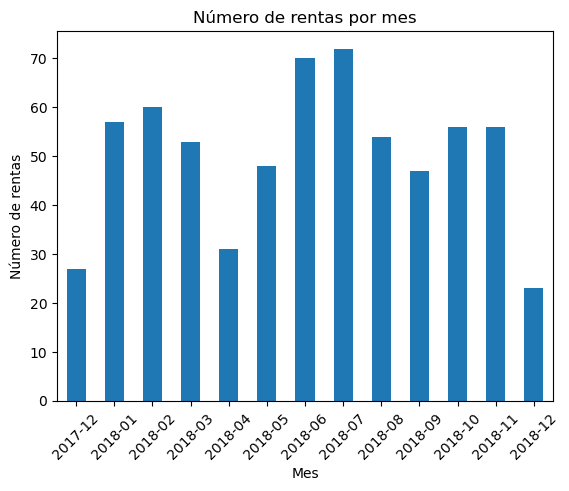

In [81]:
rentas_por_mes.plot(kind='bar')

plt.title('Número de rentas por mes')
plt.xlabel('Mes')
plt.ylabel('Número de rentas')
plt.xticks(rotation=45)

plt.show()

## Top 5 ciudades más populares para la renta de vehículos

¿Cuáles son las 5 ciudades más populares para rentar vehículos?

In [84]:
ciudad_popular = df_rental['city_start'].value_counts()
top_ciudad_popular = ciudad_popular.head()
top_ciudad_popular

Washington    101
Fort Worth    100
Dallas        100
Seattle        98
New York       89
Name: city_start, dtype: int64

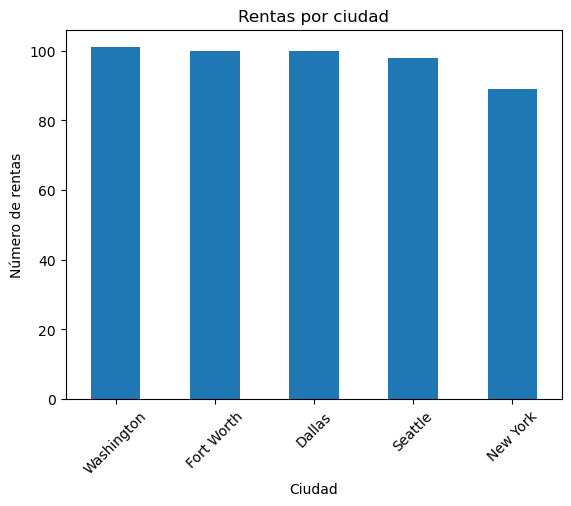

In [85]:
top_ciudad_popular.plot(kind='bar')

plt.title('Rentas por ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de rentas')
plt.xticks(rotation=45)

plt.show()

## Duración promedio de renta de vehículos en días

¿Cuánto tiempo en promedio duran las rentas de vehículos?

In [47]:
duracion_renta_promedio = (df_rental['date_end'] - df_rental['date_start']).mean().days
duracion_renta_promedio

8

## Porcentaje de rentas por opción de combustible

¿Cuál es el porcentaje de rentas con opción de combustible en el total de rentas?

In [56]:
df_fuel = (df_rental["fuel_option"].value_counts() / len(df_rental)) * 100
df_fuel

Pre-pay         34.097859
Self-Service    33.639144
Market          32.262997
Name: fuel_option, dtype: float64

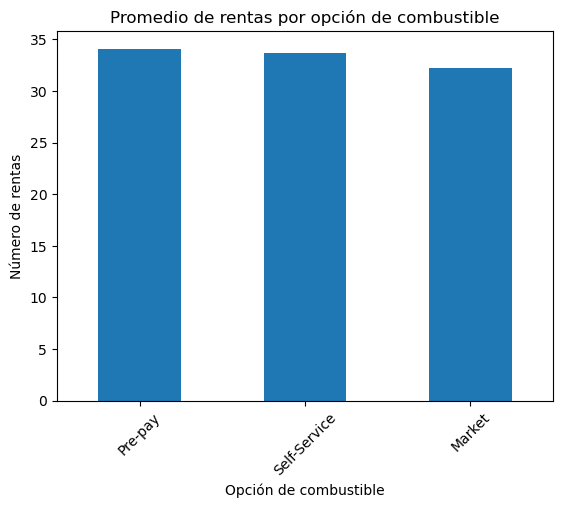

In [87]:
df_fuel.plot(kind='bar')

plt.title('Promedio de rentas por opción de combustible')
plt.xlabel('Opción de combustible')
plt.ylabel('Número de rentas')
plt.xticks(rotation=45)

plt.show()